# Assigment 1: Primitive Sensitivity Analysis
#### Moritz Kick, Rami El Immam, Maximilian Nowak

## Implementation of the model
### 1. Implement SEIR model

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display

beta = 14/9  # infection rate
alpha = 7/3  # incubation rate
gamma = 7/9  # recovery rate
i0 = 1000  # initial number of infected individuals

# Define initial conditions
N = 80e6
S0 = N - i0
E0 = 0
I0 = i0
R0 = 0
y0 = [S0, E0, I0, R0]

# Define the system of differential equations


def seir_model(y, t, beta, alpha, gamma, N):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]


# Define time points (100 Weeks)
t = np.linspace(0, 100, 100)


### 2. & 3. Plot and play with the parameters

In [213]:
# Define sliders for parameters
beta_slider = widgets.FloatSlider(
    value=0.5, min=0.0, max=5.0, step=0.01, description='beta:')
alpha_slider = widgets.FloatSlider(
    value=0.2, min=0.0, max=5.0, step=0.01, description='alpha:')
gamma_slider = widgets.FloatSlider(
    value=0.1, min=0.0, max=5.0, step=0.01, description='gamma:')
i0_slider = widgets.IntSlider(
    value=1000, min=0, max=N, step=1e6, description='i0:')

# Define a function to update the plot


def update_plot(beta, alpha, gamma, i0):
    sol = odeint(seir_model, y0, t, args=(beta, alpha, gamma, N))
    S, E, I, R = sol.T
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, 'b', label='Susceptible')
    plt.plot(t, E, 'r', label='Exposed')
    plt.plot(t, I, 'g', label='Infected')
    plt.plot(t, R, 'm', label='Recovered')
    plt.title('SEIR Model')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Population')
    plt.legend()
    plt.show()


# Display the plot and sliders
interactive_plot = widgets.interactive(
    update_plot, beta=beta_slider, alpha=alpha_slider, gamma=gamma_slider, i0=i0_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)


interactive(children=(FloatSlider(value=0.5, description='beta:', max=5.0, step=0.01), FloatSlider(value=0.2, …

## Perturbation of a nominal value
### 4. Define Hk in mathematical terms

$$
H_k := [\beta - (\beta \cdot p_k), \beta + (\beta \cdot p_k)]^T \times [\alpha - (\alpha \cdot p_k), \alpha + (\alpha \cdot p_k)]^T \times [\gamma - (\gamma \cdot p_k), \gamma + (\gamma \cdot p_k)]^T \times [I_0 - (I_0 \cdot p_k), I_0 + (I_0 \cdot p_k)]^T
$$

$$
= \beta \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix} \times
\alpha \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix} \times
\gamma \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix} \times
N_0 \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix},
$$

<center> mit </center>

$$
\beta, \alpha, \gamma, N_0 \in \R,
$$

$$
k \in \N,
$$

$$
p_k := \{x \in \R : 0 \le x \le 1 \}
$$


### 5./6./7. Include C(t), C0 = C(0) and Plot the Curve

In [205]:
# include curve for cumulative cases C(t)

# include C0
C0 = I0
y0 = [S0, E0, I0, R0, C0]

# Define the system of differential equations


def seir_model_update(y, t, beta, alpha, gamma, N):
    S, E, I, R, C = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    DCdt = alpha * E
    return [dSdt, dEdt, dIdt, dRdt, DCdt]


In [206]:
def update_plot(beta, alpha, gamma, i0):
    sol = odeint(seir_model_update, y0, t, args=(beta, alpha, gamma, N))
    S, E, I, R, C = sol.T
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, 'b', label='Susceptible')
    plt.plot(t, E, 'r', label='Exposed')
    plt.plot(t, I, 'g', label='Infected')
    plt.plot(t, R, 'm', label='Recovered')
    plt.plot(t, C, 'c', label='Cumulative cases')
    plt.title('SEIR Model')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Population')
    plt.legend()
    plt.show()


interactive_plot = widgets.interactive(
    update_plot, beta=beta_slider, alpha=alpha_slider, gamma=gamma_slider, i0=i0_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)


interactive(children=(FloatSlider(value=0.5, description='beta:', max=5.0, step=0.01), FloatSlider(value=0.2, …

### 8. Sample data (perturbations=[5 %, 10 %], N=10^3)

In [207]:
import random
rng = np.random.default_rng()

def get_hyperc(x0, pert):
    h = [0,0,0,0]
    for i in range(len(h)):
        h[i] = rng.uniform(x0[i]*(1-pert), x0[i]*(1+pert))
    return (h[0], h[1], h[2], h[3])

def run_simulations(seir_model, p, N):
    # filename = "data_sample_p" + str(int(p*100))
    # start simulation
    with open("C_data_" + str(int(p*100)), "wb") as fh1:
        with open("I_data_" + str(int(p*100)), "wb") as fh2:
            for _ in range(N):
                results = odeint(seir_model, y0, t, args=get_hyperc(x0, p))
                C_data = results[:, 4]
                np.savetxt(fh1, np.column_stack(C_data))
                I_data = results[:, 2]
                np.savetxt(fh2, np.column_stack(I_data))

# model parameters
N = 80e6
beta = 14/9
alpha = 7/3
gamma = 7/9

# inital conditions
I0 = 1000
S0 = N-I0
E0 = 0
R0 = 0
C0 = I0

# simulation time
T = 60
t = np.linspace(0, T, T+1)

x0 = (beta, alpha, gamma, N)
y0 = S0, E0, I0, R0, C0

run_simulations(seir_model_update, 0.05, N=1000)
run_simulations(seir_model_update, 0.10, N=1000)

### 9. Plot empirical distribution of C(t, x)

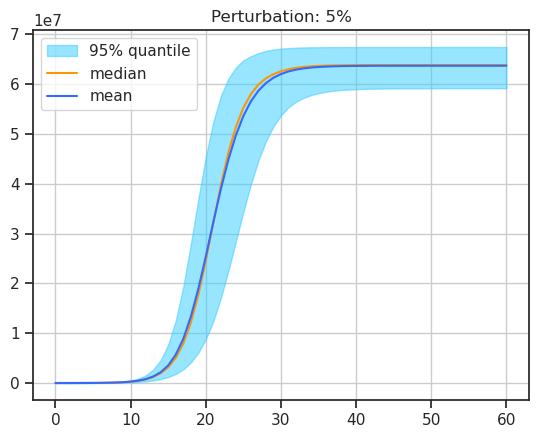

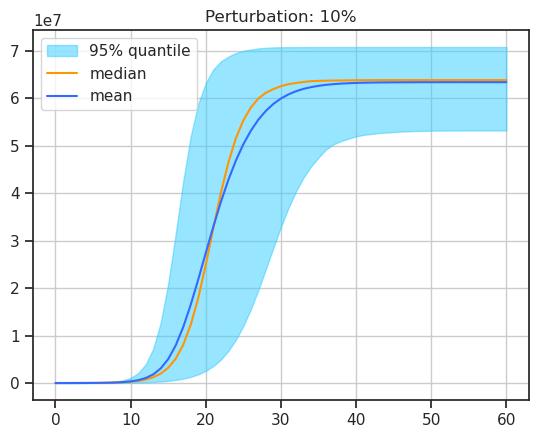

In [208]:
def get_metrics(C_data):
    n = C_data.shape[1]
    mean = C_data.mean(0)
    median = np.zeros(n)
    quant_high = np.zeros(n)
    quant_low = np.zeros(n)
    for t in range(n):
        median[t] = np.median(C_data[:, t])
        quant_high[t] = np.quantile(C_data[:, t], 0.975)
        quant_low[t] = np.quantile(C_data[:, t], 0.025)
    return mean, median, quant_high, quant_low

def plot_distribution(titlestr, metrics):
    fig, ax = plt.subplots(1, 1)
    t = np.linspace(0,T,T+1)
    ax.fill_between(t, metrics[2], metrics[3], color="#33ccff", alpha=0.5, label='95% quantile')
    ax.plot(t, metrics[1], label='median', color='#ff9600')
    ax.plot(t, metrics[0], label='mean', color='#3369ff')
    ax.set_title(titlestr)
    ax.legend()
    plt.show()

C_data5 = np.loadtxt("C_data_5")
metrics5 = get_metrics(C_data5)
plot_distribution("Perturbation: 5%", metrics5)

C_data10 = np.loadtxt("C_data_10")
metrics10 = get_metrics(C_data10)
plot_distribution("Perturbation: 10%", metrics10)


### 10. Empirical distribution of G1 and G2(X)

In [209]:
# O1(G1(x)): final number of cumulative cases
def O1(data): return data[:, -1]

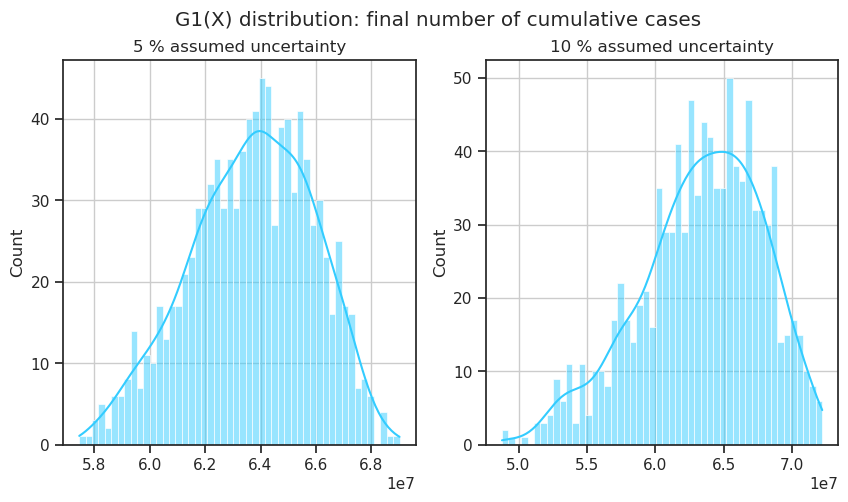

In [210]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('G1(X) distribution: final number of cumulative cases')

ax[0].set_title('5 % assumed uncertainty')

sns.histplot(ax=ax[0], data=O1(C_data5), color="#33ccff", kde=True, bins=50)
# ax[0].set_xlim(4.0, 8.0)

ax[1].set_title('10 % assumed uncertainty')
# ax[1].set_xlim(4.0, 8.0)
sns.histplot(ax=ax[1], data=O1(C_data10), color="#33ccff", kde=True, bins=50)
plt.show()

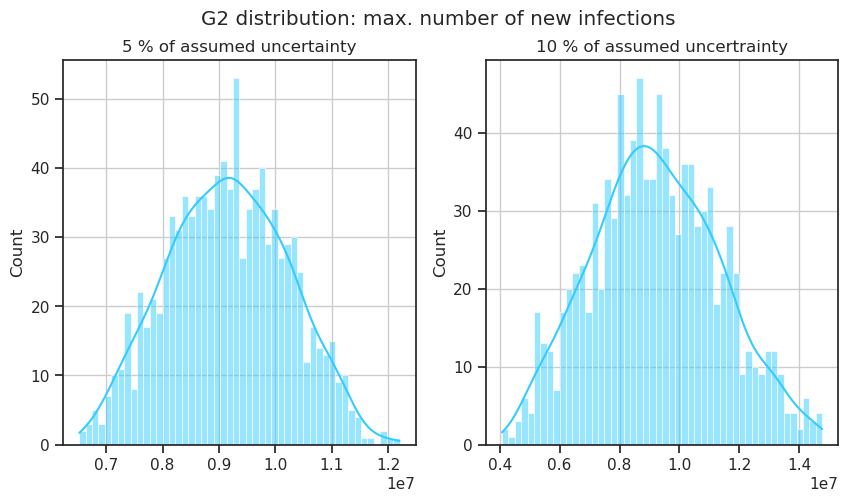

In [211]:
# O2(G2(x)): peak of infection curve
def O2(data): return np.amax(data, axis=1)

I_data5 = np.loadtxt("I_data_5")
I_data10 = np.loadtxt("I_data_10")

# plt.figure()
# plt.hist(O2(I_data5), bins=50)
# plt.show()

# plt.figure()
# plt.hist(O2(I_data10), bins=50)
# plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('G2 distribution: max. number of new infections')

ax[0].set_title('5 % of assumed uncertainty')
sns.histplot(ax=ax[0], data=O2(I_data5), color="#33ccff", kde=True, bins=50)

ax[1].set_title('10 % of assumed uncertrainty')
sns.histplot(ax=ax[1], data=O2(I_data10), color="#33ccff", kde=True, bins=50)
plt.show()


### 11: Empirical quantile intervals of $G_1(X)$ and $G_2(x)$